# Travail pratique 4
*INF600F - Traitement d'images (H2022, UQÀM)*


## Identification

- Nom : Jacob-Simard
- Prénom : Raphaël
- Code permanent : JACR26038907
- Cours : INF600f - H2022
- Équipe : 9

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from skimage import morphology, filters, measure, transform, feature, segmentation, exposure
from sklearn.cluster import KMeans
from scipy import ndimage as ndi

from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.filters import rank
from skimage.util import img_as_ubyte




im1 = imageio.imread("./tp4_ex1.png")
im2 = imageio.imread("./tp4_ex2.tif")

# Importation des modules pertinents ici.
# Assurez-vous d'inclure toute autre fonction que vous
# jugez nécessaires ici






# Exercice 1 : Reconnaissance de texte

In [2]:

def _pretraitement(img: np.ndarray, inversion:bool = False) -> np.ndarray:
    """
    Effectue le prétraitement d'une image. 
    
    Retourne une copie de l'image donnée dont l'intensité a été inversée, les valeurs ont été transformées en tons de gris et normalisées entre 0 et 1.
    @param
        img : L'image à traiter
        inversion : Contrôle d'inversion d'intensité dans l'image
    @return
        L'image transformée en grayscale, normalisée et inversée
    """
    img_traite = img.copy()
    if len(img_traite.shape) > 2 :
        # Transformation en grayscale si l'image ne l'est pas déjà
        img_traite = img_traite.mean(axis=2).astype(np.float32)
    # Normalisation de l'image entre 0 et 1
    img_traite = (img_traite - img_traite.min()) / (img_traite.max() - img_traite.min())
    
    # Inversion des intensités
    if inversion:
        img_traite = -img_traite + 1.0

    return img_traite

def _trouver_lettres_bordure(img:np.ndarray) -> np.ndarray:
    """
    Retourne une image contenant les lettres touchant la bordure de l'image donnée.

    @param
        img : L'image pour laquelle on veut trouver les lettres qui touchent la bordure.
    @return
        Une image contenant seulement les lettres touchant la bordure.
    """
    prev = None

    # On sélectionne seulement les bordures 
    curr = img.copy()
    curr[1:-1, 1:-1] = 0.0

    # Dilatation géodésique
    while np.not_equal(prev, curr).any():
        prev = curr.copy()
        curr = np.logical_and(img, morphology.binary_dilation(curr))

    return curr

def _segmentation(img:np.ndarray) -> tuple[np.ndarray, int]:
    """
    Traite l'image donnée, la segmente et retourne une image contenant les lettres segmentées ainsi que le nombre de lettres.

    @param
        img : l'image à traiter
    @return 
        un tuple contenant une image des lettres segmentées et un entier représentant le nombre de lettres.
    """
    traite = _pretraitement(img, True)

    # On fait une ouverture pour éliminer les connexions entre lettres autant que possible.
    seg = morphology.opening(traite)

    # Seuillage global pour binariser
    otsu = filters.threshold_otsu(seg)
    seg[ seg <= otsu]  = 0.0
    seg[seg > otsu] = 1.0

    # On trouve les lettres qui touchent la bordure de l'image et on les enlève.
    lettres = _trouver_lettres_bordure(seg)
    seg = (seg - lettres).astype(int)

    return measure.label(seg, return_num = True)

def _extraction(labels: np.ndarray, nbr_label:int) -> list[np.ndarray]:
    """
    Identifie chaque lettre et l'échantillone dans une image 24x24. Ces images sont
    retournées dans une liste.
    
    @param
        labels : une image avec les différents objets identifiés
        nbr_label : Le nombre d'objets identifiés dans l'image
    @return
        Une liste contenant les objets identifiés sous forme d'image 24x24
    """
    lettres = []
    # On itère sur les labels
    for lettre in range(1, nbr_label):
        curr_label = labels.copy()

        # On extrait la lettre qui nous intéresse et on trouve ses coordonnées.
        curr_label[curr_label != lettre] = 0
        curr_label[curr_label == lettre] = 1
        i, j = np.where(curr_label == 1)

        # On rogne pour ne garder que la lettre et on ajoute du padding.
        curr_label = curr_label[i.min():i.max()+1, j.min()-3:j.max()+1]
        curr_label = np.pad(curr_label, 3)

        # On agrandie l'image pour avoir des dimensions égales sans perdre de l'information puis on rapetisse aux dimensions 24x24
        curr_label = transform.resize(curr_label, (72,72), mode="constant", cval = 0, anti_aliasing=True)
        curr_label = transform.downscale_local_mean(curr_label, (3,3))

        lettres.append(curr_label)
    return lettres
        
def display_randomImages(coll_img : list[np.ndarray], nbr_a_afficher:int = 12):
    """
    Affiche les images dans coll_img

    @param
        coll_img : Une liste d'images
        nbr_a_afficher (default 12) : le nombre d'images de la liste à afficher

    """
    # Génération d'une liste de 'nbr_a_afficher' nombre
    a_afficher = np.random.randint(len(coll_img), size=(nbr_a_afficher))

    # Bornes pour l'affichage
    nbr_lignes = ceil(nbr_a_afficher / 4) if nbr_a_afficher > 4 else 1
    nbr_colonnes = 4 if nbr_lignes > 1 else nbr_a_afficher

    # affichage de 'nbr_a_afficher' images
    curr = 1
    plt.figure(figsize=(15,15))
    for elem in a_afficher:
        plt.subplot(nbr_lignes, nbr_colonnes, curr)
        plt.title(f"lettre {elem}")
        plt.imshow(coll_img[elem])
        curr += 1
    plt.show()




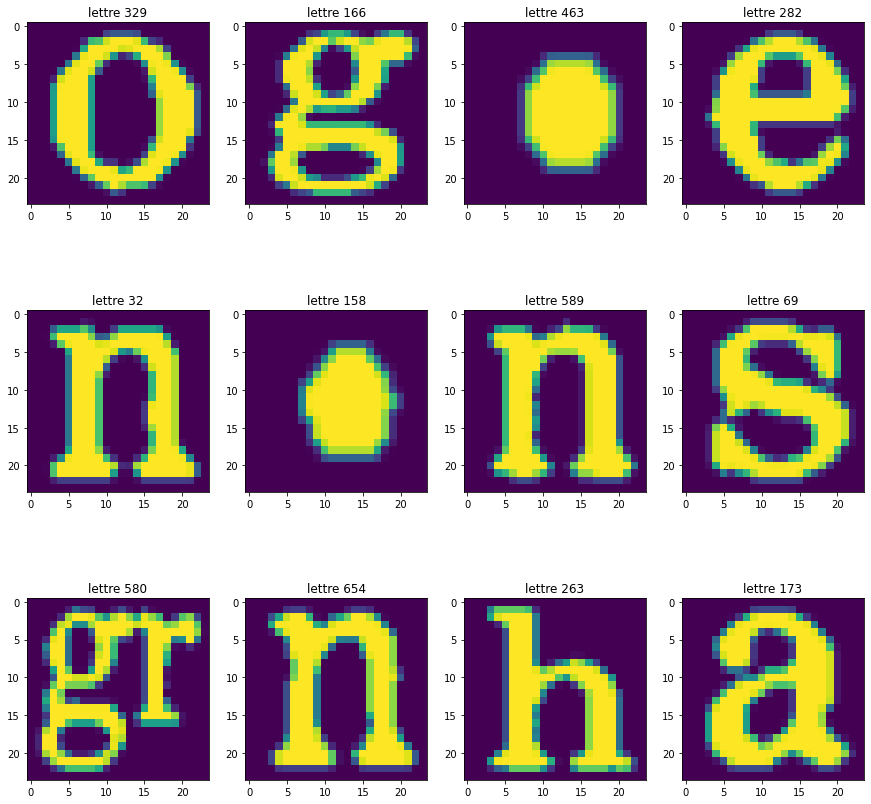

In [3]:

# prétraitement et segmentation de l'image
seg, num = _segmentation(im1)

# Extraction des lettres
coll_lettres = _extraction(seg, num)

# affichage de 12 lettres
display_randomImages(coll_lettres)





#### Question : Combien de lettres avez-vous détectées dans cette image?

La liste des lettres contient 706 éléments. Ces éléments ne sont pas tous des lettres, il y a aussi des points de ponctuation et certaines lettres ne sont pas bien séparées. Il est donc difficile à dire combien de lettres ont été détectées, mais on peut estimer autour de 700 lettres.

#### Question : En observant les lettres segmentées, pouvez-vous identifier des situations pour lesquelles le pipeline de traitement d’images proposé plus haut échoue à extraire une lettre isolée ? Que suggérez-vous pour améliorer les performances de l’extraction des lettres ?

Certaines lettres sont parfois trop proches l'une de l'autre pour être séparées par l'ouverture et la segmentation globale avec otsu. Ces couples ou triplets de lettres sont donc considérés comme une seule lettre, ce qui fausse le reste du pipeline.

J'ai essayer plusieurs combinaisons d'érosion/dilatation ou opening/closing, avec un seuillage global additionnel ou sans, etc. Rien ne semble fonctionner complètement.

Je doute fortement qu'une opération de type watershed fonctionne, mais ce que je pense qui pourrait être efficace serait de prendre une image type de chaque lettre et d'en faire une skeletisation. On pourrait ensuite les utiliser comme footprint pour une érosion sur les lettres qui sont mal extraites. Ensuite, on segmente à nouveau et l'on reconstitue les nouvelles lettres extraites à l'aide d'une dilatation géodésique.

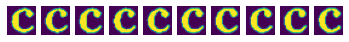

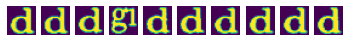

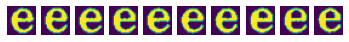

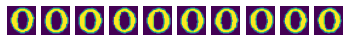

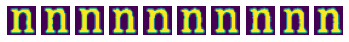

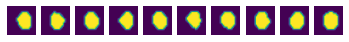

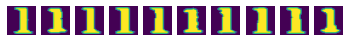

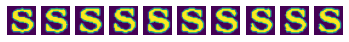

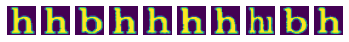

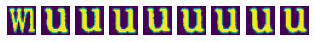

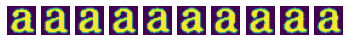

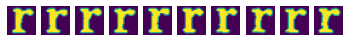

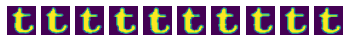

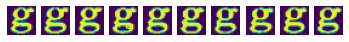

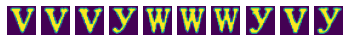

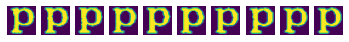

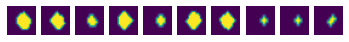

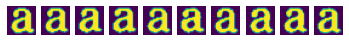

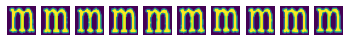

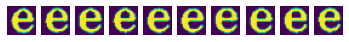

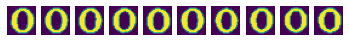

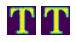

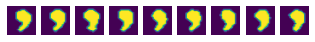

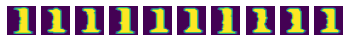

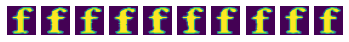

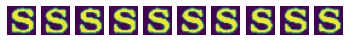

In [4]:
# KMean

# On génère les attributs de chaque image
attr = []
for img in coll_lettres:
    attr.append(feature.hog(img))

# Entrainement du modèle
modele = KMeans(n_clusters=26).fit(attr)

# Stockage des différentes images selon leurs classes respectives 
classes = [[] for _ in range(27)]
for i in range(len(modele.labels_)):
    classes[modele.labels_[i]].append(coll_lettres[i])

# Affichage d'un maximum de 10 éléments pour chaque classe.
for elem in classes:
    if elem:
        curr = 1
        for nbr in range(min(10,len(elem))):
            plt.subplot(1,10,curr)
            plt.imshow(elem[nbr])
            plt.axis('off')
            curr +=1
        plt.show()

#### Commentaires sur les résultats de KMeans

On peut voir qu'en général le classement a été plutôt bien réussi, bien que la présence d'erreurs dans l'extraction des lettres fausse un peu les résultats. Il y a des erreurs(duplication de classes similaires, mauvais classements), mais ces erreurs sont assez typiques pour KMeans. 

En effet, avoir à choisir le 'k' approprié et le placement des noyaux initiaux va souvent donner des erreurs de classification puisque l'algorithme est 'bête' et ne fait que fonctionner sur le voisinage de chaque noyau et que l'efficacité est hautement affectée par le hasard.

Dans ce cas-ci, si on voulait toujours utiliser KMean, il faudrait probablement augmenter 'k' et procéder à des unions manuellement après la classification.

Je me demande si un algorithme hiérarchique ou DBscan fonctionnerait mieux.

# Exercice 2 : Compter des cellules

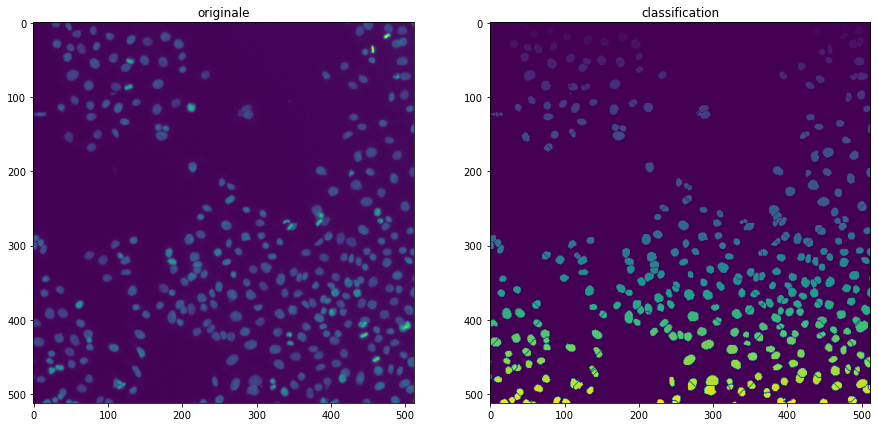

417


In [8]:
# Prétraitement de l'image en tons de gris.
# Pas besoin de faire l'inversion des intensités, l'avant-plan est déjà bien démarqué.
traite = _pretraitement(im2)

# Seuillage global avec otsu pour enlever l'arrière-plan.
traite[traite <= filters.threshold_otsu(traite)] = 0
traite[traite > filters.threshold_otsu(traite)] = 1

# Calcul de la distance de chaque point vers le zéro le plus proche pour trouver les cercles.
# Ces distances sont ensuite utilisées pour calculer les points d'intensité les plus forts d'une région.
distance = ndi.distance_transform_edt(traite)

# Calcul des coordonnées du centre de chaque cercle.
# Ces coordonnées sont les points d'intensité les plus forts des différentes régions.
# On utilise un disque comme élément structurant puisque les cellules ressemblent à des cercles.
# Bien entendu, les cellules n'ont pas toutes la même taille alors le disque aura un effet variable.
coords = feature.peak_local_max(distance, footprint=morphology.disk(3), labels=traite.astype(np.int32))

# Création du marker pour le watershed.
# Un masque avec les coordonnées des points d'intensité les plus forts.
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)

# Segmentation avec watershed
# On utilise watershed pour séparer les différentes cellules à partir du marker.
# Malheureusement, puisque plusieurs markers peuvent faire partie d'une même cellule, il arrive qu'une cellule soit segmentée alors qu'elle ne devrait pas l'être.
# Cette technique fonctionne très bien pour trouver les cellules qui sont collées ou superposées.
seg = segmentation.watershed(-distance, markers, mask=traite, watershed_line = True)

# Identification des cellules individuelles
labels, num = measure.label(seg, return_num = True)


# Affichage avant/après
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("originale")
plt.imshow(im2)
plt.subplot(122)
plt.title("classification")
plt.imshow(labels)

plt.show()
print(num)

On a donc 417 cellules dans cette image. Ce nombre n'est pas exact puisque le processus utilisé sépare bien les cellules collées, mais tend à trop segmenter les cellules ayant plusieurs points forts d'intensité. On peut contrôler le niveau de segmentation en modifiant l'élément structurant utilisé lors du calcul des maximums locaux : si on l'agrandit, on segmente moins les cellules individuelles, mais on trouve moins de cellules collées.

Il existe certainement un processus qui obtient un résultat plus exact, mais je pense que ce que j'ai fait donne une bonne estimation.